In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [6]:
import os 
import numpy as np
DATA_PATH = os.path.join('MP_Data')

actions = np.array(["Despatch Aircraft","Hold Position","Normal Stop","OpenClose Stairs","Release Brakes","Set Brakes","Slow Down","Straight Ahead","Turn Left","Turn Right"])
no_sequences = 30
sequence_length = 90

In [7]:
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label:num for num, label in enumerate(actions)}

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [10]:
model = keras.Sequential()
model.add(keras.layers.LSTM(512, input_shape=(90, 1662), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(256, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
model.load_weights('action3.h5')

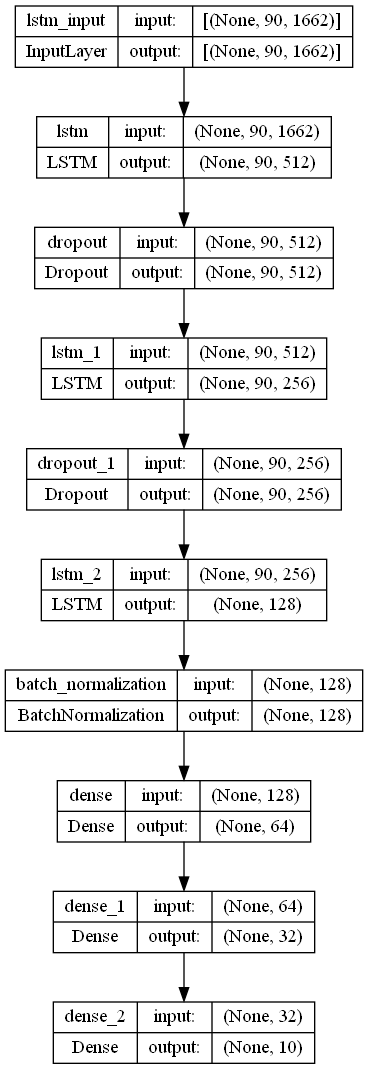

In [12]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
colors = [(245,117,16), (117,245,16), (16,117,245),(117,16,245),(245,16,117),(16,200,78),(200,78,16),(78,16,200),(16,78,200),(78,200,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), int(90+num*40)), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [14]:
sequence = []
sentence = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture("video.mp4") # For file input
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        # frame = cv2.flip(frame, 1)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-90:]
        
        if len(sequence) == 90:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (940, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        print(sentence)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()

    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[]
<class 'mediapipe.python.solution_base.S